# V1 L4 Model 

V1 L4 model 

In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import logging
#
import airavata_cerebrum.model.setup as cbm_setup
import airavata_cerebrum.view.tree as cbm_tree
import airavata_cerebrum.model.recipe as cbm_recipe
import mousev1.model as mousev1


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Aug 27 2024 04:32:09

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



# Setup the Model Recipe and the Recipe Templates

Model recipe is defined by a recipe file named recipe.json and template file name recipe_template.json. 
The files are placed in the recipe directory, canonically under the base directory of the model.

## recipe.json

recipe.json contains two sections: (1) data2model_map and (2) source_data. 
data2model_map maps between how the different parts of the model map to the source data. 
The source_data describes how the source databases are connected and different operations such as filters are applied to the data available from the specific database.

In [3]:
custom_mod_file = "./v1l4/recipe/custom_mod.json"
m_base_dir = "./"
m_name = "v1l4"
rcp_files = {"recipe": ["recipe.json"], "templates": ["recipe_template.json"] }
rcp_dir = "./v1l4/recipe/"
custom_mods = cbm_recipe.netstruct_from_file(custom_mod_file)
mdr_setup = cbm_setup.init_model_setup(
    name=m_name,
    base_dir=m_base_dir,
    recipe_files=rcp_files,
    recipe_dir=rcp_dir,
)


In [4]:
import IPython.display
import json
with open("./v1l4/recipe/recipe.json") as ifx:
    config_dict = json.load(ifx)
IPython.display.JSON(config_dict)

<IPython.core.display.JSON object>

# Visualize Structure for Source Data 

Data provider module includes
  - Methods for defining the querying from the database and filter the data based on specific criteria. 
  - Utilities to visualize the data provider configurations in easy-to-understand explorer view inside Jupyter notebook with the relevant parameters displayed in the side panel.

Construction of Layer 4 of Mouse V1 is shown below with three different data providers: 
  - Allen Cell Types database,
  - Allen Brain Cell Atlas and
  - AI Synaptic Physiology Database. 

Using the templates we can view the links to the source data and the model with Jupter notebook widgets. Running the next cell should produce a visualization in the image below:

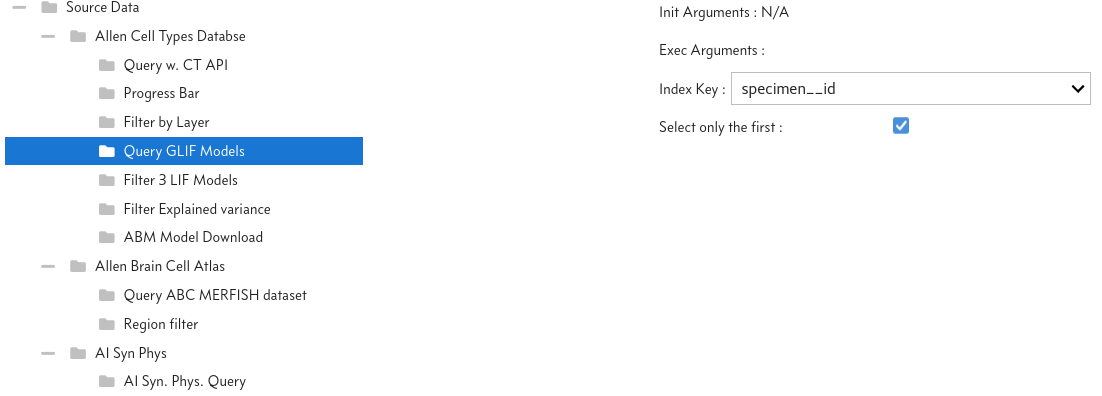

In [5]:
sd_tree = cbm_tree.DataSourceRecipeView(mdr_setup, left_width="55%")
sd_tree.build()
sd_tree.layout

TwoByTwoLayout(children=(Tree(data={'id': '-source_data', 'text': 'Data Sources', 'state': {'selected': True, …

# Data2Model Map

Definitions for data2model includes two parts:

1. *Locations:* Cell types database and the MERFISH atlas data map to neuron models and the distribution of neuron types, respectively
2. *Connections:* AI synaptic physiology data is mapped to the connection probabilities between the pairs of neuron classes.     

## View for Locations

Locations are defined hiearchially with each section defining the data links. For V1 layer 4, we map five different neuron types to the specific models and the region fractions.

Using the templates we can view the links to the neurons and the source data with Jupter notebook widgets. Running the next cell should produce a visualization in the image below:

## View for Connections

Connections are defined as section for each pair to neuron sets, with each section defining the data links. For V1 layer 4, we map eight different neuron pairs to the AI Syn. Phys. Data outputs.

Using the templates we can view the links to the neuron pairs and the source data with Jupter notebook widgets. Running the next cell should produce a visualization in the image below:




In [6]:
dm_tree = cbm_tree.Data2ModelRecipeView(mdr_setup, width="55%")
dm_tree.build()
dm_tree.layout

TwoByTwoLayout(children=(Tree(data={'id': '-data2model_map', 'text': 'Data->Model', 'state': {'selected': True…

## Custom Modification

Custom modifications if defined byt the "custom_mod.json". It includes:
- Users can provide details required for network construction that are either not available in the linked databases or over-ride specific information.
- Utilities to visualize these modifications in Jupyter Notebook.

For the Layer 4 of Mouse V1, custom modifications include 
1. Dimensions of each region in the model.
2. Connection Parameters not available with the AI Syn. Phys. database.
3. Details of the networks that are external to V1  LGN and the  background networks. 

Using the templates we can view the user custom modifications with Jupter notebook widgets. Running the next cell should produce a visualization in the image below:

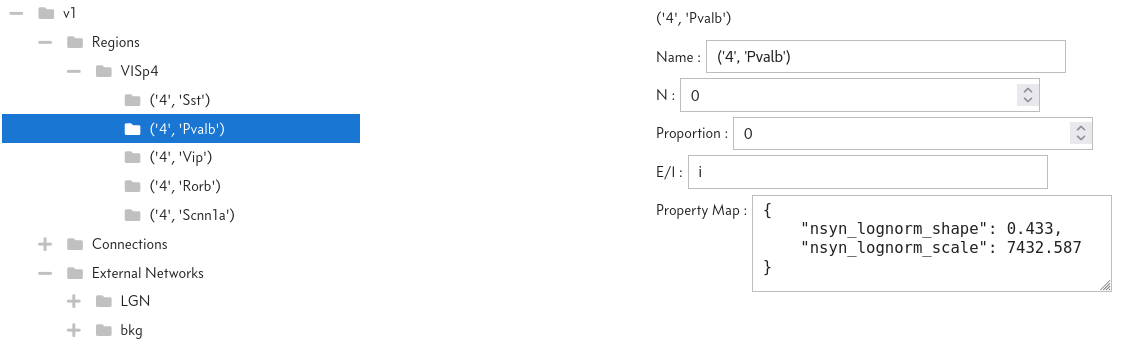

In [7]:
import IPython.display
import json
with open(custom_mod_file) as ifx:
    custom_mod_dict = json.load(ifx)
IPython.display.JSON(custom_mod_dict)

<IPython.core.display.JSON object>

In [8]:
cmod_view = cbm_tree.NetworkStructureView(custom_mods, left_width="55%")
cmod_view.build()
cmod_view.layout

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



TwoByTwoLayout(children=(Tree(data={'id': '-User-Mod-V1L4', 'text': 'User-Mod-V1L4', 'state': {'selected': Tru…

## Mappers for *Model Recipe* to *SONATA Network*
To realize model recipe 
1. *Region Mapper* : Maps the location to a region in the network
2. *Neuron Mapper* : Map the neuron details in the location to a neuron class within the region
3. *Connection Mapper*: Map the connection data to a connection object

In addition a *Network Builder* class is also defined that translates the model description to SONATA network. 

In [9]:
model_recipe = cbm_recipe.ModelRecipe(
    recipe_setup=mdr_setup,
    region_mapper=mousev1.V1RegionMapper,
    neuron_mapper=mousev1.V1NeuronMapper,
    connection_mapper=mousev1.V1ConnectionMapper,
    network_builder=mousev1.V1BMTKNetworkBuilder,
    mod_structure=custom_mods,
    save_flag=True,
    write_duck=True,
)

# logging.basicConfig(level=logging.INFO)

# Data Acquistition

Data acquisition consists of the following two steps:

## Run Data Download Workflow

After the model description is defined and updated with custom user modifications, the download workflow proceeds as follows:
1. Download the data
2. Apply the filters and transormations
3. Map data to the model components
4. Apply user modifications
5. Build the SONATA file

## Run Download Post Operations

After data is dowloaded, the data obtained from different databases need to processed separately:

1.  In case of the Allen Cell Type database, the download step can be restricted only to obtain the metadata related to cell types. After the meta data is downloaded, we need to acquire the models of interest (3 LIF Models). We use the GLIF API from allensdk to download these 3LIF model with a explained variance threshold.
2.  For data from Allen Brain Cell Atlas, we filter the data specific to only the VISp Layer 4
3.  For AI Syn Phys. data, we select only the neuron pairs of our interest.

We accomplish the above two steps by running acquire_source_data() function.

In [10]:
db_source_data = model_recipe.acquire_source_data()

  0%|          | 0/2333 [00:00<?, ?it/s]

/storage/hive/project/cse-aluru/schockalingam6/spack/opt/spack/linux-rhel9-cascadelake/gcc-12.3.0/miniforge3-24.3.0-0-aqhmckaascr5r262m24t2yk3fjx52dqs/envs/cerebrum/lib/python3.10/site-packages/aisynphys/connectivity.py:323: RuntimeWarning:Mean of empty slice.
/storage/hive/project/cse-aluru/schockalingam6/spack/opt/spack/linux-rhel9-cascadelake/gcc-12.3.0/miniforge3-24.3.0-0-aqhmckaascr5r262m24t2yk3fjx52dqs/envs/cerebrum/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:invalid value encountered in double_scalars
/storage/hive/project/cse-aluru/schockalingam6/spack/opt/spack/linux-rhel9-cascadelake/gcc-12.3.0/miniforge3-24.3.0-0-aqhmckaascr5r262m24t2yk3fjx52dqs/envs/cerebrum/lib/python3.10/site-packages/aisynphys/connectivity.py:329: RuntimeWarning:invalid value encountered in long_scalars
/storage/hive/project/cse-aluru/schockalingam6/spack/opt/spack/linux-rhel9-cascadelake/gcc-12.3.0/miniforge3-24.3.0-0-aqhmckaascr5r262m24t2yk3fjx52dqs/envs/cerebrum/lib/python3

# Explore downloaded data

Output data are stored in the description directory in json format (db_connect_output.json), which can be examine with json library. Here are examples of Region and Neuron fractions of the Allen Brain Atlas, and connectivity matrix downloaded from AI Syn. Phys. dataset

In [11]:
import json
#
with open("./v1l4/recipe/db_connect_output.json") as dbf:
    db_out_data = json.load(dbf)

In [12]:
import airavata_cerebrum.dataset.abc_mouse as abcm
abcm.DFBuilder.build(db_out_data['airavata_cerebrum.dataset.abc_mouse'])

Region,Layer,nregion,inhibitory fraction,fraction wi. region,Vip fraction,Pvalb fraction,Sst fraction,Lamp5 fraction,Sst-Chodl fraction,IT-ENT fraction,IT-CTX fraction,IT-Other fraction,ET fraction,CT fraction,NP fraction,IT fraction
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""VISp""","""1""",61884,0.405155,0.069663,0.147583,0.038168,0.035623,0.720102,0.007634,0.001733,0.986135,0.001733,0.0,0.0,0.0,0.989601
"""VISp""","""2/3""",61884,0.078755,0.34862,0.31669,0.332382,0.161912,0.158345,0.00214,0.0,1.0,0.0,0.0,0.0,0.0,1.0
"""VISp""","""4""",61884,0.111916,0.209699,0.131933,0.532773,0.315126,0.018487,0.0,0.0,0.962618,0.0,0.029334,0.000212,0.007413,0.962618
"""VISp""","""5""",61884,0.165428,0.177606,0.021739,0.487681,0.455797,0.022464,0.006522,0.001867,0.519247,0.000144,0.323039,0.043953,0.104137,0.521258
"""VISp""","""6a""",61884,0.062779,0.163661,0.038321,0.562044,0.34854,0.025547,0.010949,0.001711,0.212443,0.001834,0.000611,0.75932,0.005378,0.215988
"""VISp""","""6b""",61884,0.05291,0.030751,0.0375,0.475,0.275,0.0875,0.075,0.0,0.042598,0.00419,0.0,0.725559,0.0,0.046788


In [13]:
import airavata_cerebrum.dataset.ai_synphys as aisp
aisp.DFBuilder.build(db_out_data['airavata_cerebrum.dataset.ai_synphys'])

pre_synapse,post_synapse,connect_prob
str,str,f64
"""L4-Pyr""","""L4-Pyr""",0.125985
"""L4-Pyr""","""L4-Pvalb""",0.198113
"""L4-Pyr""","""L4-Sst""",0.045855
"""L4-Pyr""","""L4-Vip""",0.049624
"""L4-Pvalb""","""L4-Pyr""",0.356604
…,…,…
"""L4-Sst""","""L4-Vip""",0.306504
"""L4-Vip""","""L4-Pyr""",0.0
"""L4-Vip""","""L4-Pvalb""",0.025412


## Mapping Source data

In this step, the data downloaded is mapped to the locations and the connection pairs as mentioned in "Data2Model Map" section above.

A snapshot of the mapping is shown below:


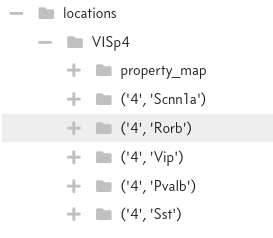 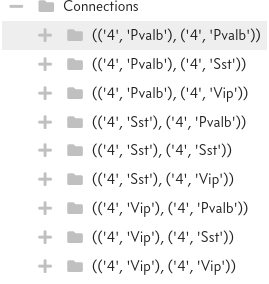

In [14]:
logging.basicConfig(level=logging.INFO)
#
msrc = model_recipe.map_source_data()

INFO:airavata_cerebrum.workflow:Processing db connection for neuron [property_map]
INFO:airavata_cerebrum.workflow:Start op workflow for db [airavata_cerebrum.dataset.abc_mouse]
INFO:airavata_cerebrum.workflow:Running XFormer : [Select Region]
INFO:airavata_cerebrum.workflow:Complete XForm : [Select Region]
INFO:airavata_cerebrum.workflow:Complete op workflow for db [airavata_cerebrum.dataset.abc_mouse]
INFO:airavata_cerebrum.workflow:Completed db connection for neuron [property_map]
INFO:airavata_cerebrum.workflow:Processing db connection for neuron [('4', 'Scnn1a')]
INFO:airavata_cerebrum.workflow:Start op workflow for db [airavata_cerebrum.dataset.abm_celltypes]
INFO:airavata_cerebrum.workflow:Running XFormer : [Select Line]
INFO:airavata_cerebrum.operations.dict_filter:CTDbCellAttrFilter Args : {'key': 'ct', 'filters': [['line_name', '__contains__', 'Scnn1a'], ['cell_reporter_status', '__eq__', 'positive']]}
INFO:airavata_cerebrum.workflow:Complete XForm : [Select Line]
INFO:airava

# Apply User Modification

As mentioned in the "User Modification" section above user updates for the model are loaded from "./v1l4/description/custom_mod.json".

For V1L4, the user modification include dimension, additional connection properties, and properties of external netowrks


In [15]:
import IPython.display
import json
with open("./v1l4/recipe/custom_mod.json") as ifx:
    custom_mod_dict = json.load(ifx)
IPython.display.JSON(custom_mod_dict)

<IPython.core.display.JSON object>

In [16]:
msrc = model_recipe.build_net_struct()
msrc = model_recipe.apply_mod()

In [17]:
bmtk_net_builder = mousev1.V1BMTKNetworkBuilder(model_recipe.network_struct)
bmtk_net = bmtk_net_builder.build()

('4', 'Scnn1a') 501023852 310 2322
('4', 'Scnn1a') 323838579 310 2322
('4', 'Scnn1a') 500964358 310 2322
('4', 'Scnn1a') 395785266 310 2322
('4', 'Scnn1a') 476266853 310 2322
('4', 'Scnn1a') 320207387 310 2322
('4', 'Scnn1a') 517647182 310 2322
('4', 'Scnn1a') 325464516 310 2322
('4', 'Scnn1a') 476218657 310 2322
('4', 'Rorb') 322723785 111 2322
('4', 'Rorb') 478586425 111 2322
('4', 'Rorb') 329557305 111 2322
('4', 'Rorb') 500859045 111 2322
('4', 'Rorb') 479179020 111 2322
('4', 'Rorb') 324065524 111 2322
('4', 'Rorb') 322761772 111 2322
('4', 'Rorb') 467357834 111 2322
('4', 'Rorb') 329550277 111 2322
('4', 'Rorb') 476562817 111 2322
('4', 'Rorb') 466378900 111 2322
('4', 'Rorb') 486472847 111 2322
('4', 'Rorb') 480648382 111 2322
('4', 'Rorb') 490626827 111 2322
('4', 'Rorb') 479508018 111 2322
('4', 'Rorb') 490626718 111 2322
('4', 'Rorb') 484770879 111 2322
('4', 'Rorb') 500894271 111 2322
('4', 'Rorb') 485836906 111 2322
('4', 'Rorb') 480124551 111 2322
('4', 'Rorb') 469763389 1

In [18]:
bmtk_net_builder.net.save(str(mdr_setup.network_dir))
bmtk_net_builder.bkg_net.save(str(mdr_setup.network_dir))

## Running the SONATA Network in NEST

1. Convert downloaded models to NEST confirmed models
2. Load SONATA network in NEST
3. Run Simulation

In [19]:
# Converting to 
import mousev1.operations as mousev1ops
import nest
import matplotlib.pyplot as plt

mousev1ops.convert_ctdb_models_to_nest("./v1l4/components/point_neuron_models/", "./v1l4/components/cell_models/")

In [20]:

config_file = "./v1l4/config_nest.json"
# Instantiate SonataNetwork
sonata_net = nest.SonataNetwork(config_file)

# Create and connect nodes
node_collections = sonata_net.BuildNetwork()
print("Node Collections", node_collections.keys())



Apr 01 15:07:29 correlospinmatrix_detector [Info]: 
    Default for delta_tau changed from 0.1 to 0.25 ms

Apr 01 15:07:29 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.25 ms.
Node Collections dict_keys(['v1l4', 'bkg'])


In [21]:
# Connect spike recorder to a population
spike_rec = nest.Create("spike_recorder")
nest.Connect(node_collections["v1l4"], spike_rec)

# Attach Multimeter
multi_meter = nest.Create(
    "multimeter",
    params={
        # "interval": 0.05,
        "record_from": ["V_m", "I", "I_syn", "threshold", "threshold_spike", "threshold_voltage", "ASCurrents_sum"],
    },
)
nest.Connect(multi_meter, node_collections["v1l4"])

# Simulate the network
sonata_net.Simulate()


Apr 01 15:07:31 NodeManager::prepare_nodes [Info]: 
    Preparing 6489 nodes for simulation.

Apr 01 15:07:31 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 6489
    Simulation time (ms): 3000
    Number of OpenMP threads: 1
    Not using MPI

Apr 01 15:07:42 SimulationManager::run [Info]: 
    Simulation finished.


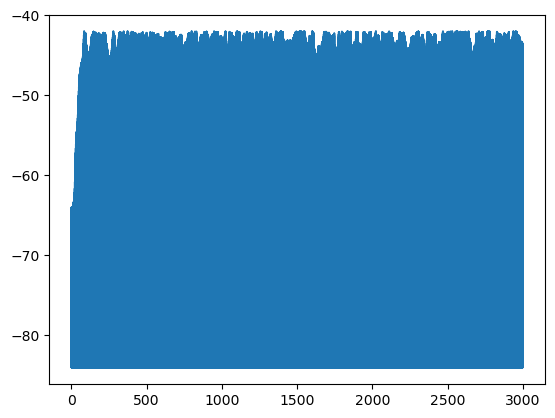

In [22]:
dmm = multi_meter.get()
Vms = dmm["events"]["V_m"]
ts = dmm["events"]["times"]
#
plt.figure(1)
plt.plot(ts, Vms)

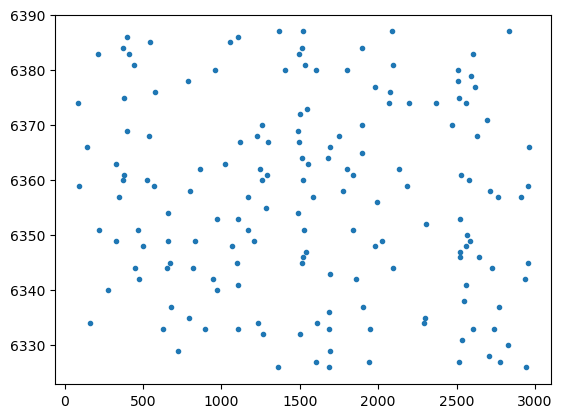

In [23]:
spike_data = spike_rec.events
spike_senders = spike_data["senders"]
ts = spike_data["times"]
plt.figure(2)
plt.plot(ts, spike_senders, ".")
plt.show()